In [14]:
import torch.cuda
import sys

sys.path.append('..')
SEED=1

from src.henry.mnist_vae_pure import VariationalAutoencoder
import torchvision
import torchvision.datasets as datasets
import pickle
from matplotlib import pyplot as plt
import numpy as np
from utils import * 
from WeightsModification import * 
from federated_pure import federate




In [15]:
class FakeArgs:
    def __init__(self):
        self.seed=4237987
        self.epochs = 10
        self.dataset = "mnist"
        self.num_users=6
        self.iid = 4
        self.dirichlet = 0.5 
        self.local_ep=10
        self.local_bs=64
        self.beta=1.0
        self.frac_split=0.4
    # def __init__(self):
    #     self.seed=SEED
    #     self.epochs = 25
    #     self.dataset = "fmnist"
    #     self.num_users=10
    #     self.iid = 2
    #     self.dirichlet = 0.5 
    #     self.local_ep=10
    #     self.local_bs=64
    #     self.beta=1.0
        

In [2]:
alpha_values = [0.1,0.5,1.0,2.0]
vae_beta_values = [1.0,5.0,10.0]

for vae_beta_val in vae_beta_values:
    runtime_args = FakeArgs()
    runtime_args.beta=vae_beta_val
    
    baseline_result = federate(runtime_args)
    baseline_result.serialise("baseline", runtime_args)
    
    for alpha in alpha_values:
        new_weights = calculate_new_weights(baseline_result.global_model.encoder, baseline_result.client_datasets, alpha,0.0)

        second_res = federate(runtime_args,new_weights, baseline_result.client_datasets)
        second_res.serialise("alpha_" + str(alpha),runtime_args)
        
    
    
    
    
    





NameError: name 'federate' is not defined

In [16]:
# vae, ovr_losses, mse_losses, kl_losses = vae.train_model(dataset_train,16,10)
# print(mse_losses)
# print(kl_losses)
# 46 -> 34
res = federate(FakeArgs())
res.serialise("BOGUS_TEST",FakeArgs())





  0%|          | 0/10 [00:00<?, ?it/s]


 | Global Training Round : 1 |

Training user 0 in round 1
Finished local epoch 1 out of 10, average loss across batches: 608.6302964520303
Finished local epoch 2 out of 10, average loss across batches: 556.1207360917596
Finished local epoch 3 out of 10, average loss across batches: 547.034301174674
Finished local epoch 4 out of 10, average loss across batches: 541.8635823438123
Finished local epoch 5 out of 10, average loss across batches: 538.9225973141421
Finished local epoch 6 out of 10, average loss across batches: 535.5216729230941
Finished local epoch 7 out of 10, average loss across batches: 533.4618448634056
Finished local epoch 8 out of 10, average loss across batches: 532.2596835968601
Finished local epoch 9 out of 10, average loss across batches: 530.0951845205514
Finished local epoch 10 out of 10, average loss across batches: 528.8942431796129
Training user 1 in round 1
Finished local epoch 1 out of 10, average loss across batches: 476.758906139027
Finished local epoch 2 

 10%|█         | 1/10 [01:36<14:25, 96.20s/it]

TEST LOSS AT GLOBAL ROUND 1 totalL: 654.5539694671631

 | Global Training Round : 2 |

Training user 0 in round 2
Finished local epoch 1 out of 10, average loss across batches: 564.1364645016421
Finished local epoch 2 out of 10, average loss across batches: 546.1647918118033
Finished local epoch 3 out of 10, average loss across batches: 540.5470003747637
Finished local epoch 4 out of 10, average loss across batches: 537.089224262602
Finished local epoch 5 out of 10, average loss across batches: 533.8889550859002
Finished local epoch 6 out of 10, average loss across batches: 531.9108340512415
Finished local epoch 7 out of 10, average loss across batches: 529.8346118319566
Finished local epoch 8 out of 10, average loss across batches: 528.2138302553991
Finished local epoch 9 out of 10, average loss across batches: 526.6410862625025
Finished local epoch 10 out of 10, average loss across batches: 524.9367211214296
Training user 1 in round 2
Finished local epoch 1 out of 10, average loss ac

 20%|██        | 2/10 [03:11<12:46, 95.79s/it]

TEST LOSS AT GLOBAL ROUND 2 totalL: 609.7734908294677

 | Global Training Round : 3 |

Training user 0 in round 3
Finished local epoch 1 out of 10, average loss across batches: 544.3294310357161
Finished local epoch 2 out of 10, average loss across batches: 530.9617908259106
Finished local epoch 3 out of 10, average loss across batches: 527.3191044315411
Finished local epoch 4 out of 10, average loss across batches: 525.0386978440984
Finished local epoch 5 out of 10, average loss across batches: 523.4159141589122
Finished local epoch 6 out of 10, average loss across batches: 522.0549714884181
Finished local epoch 7 out of 10, average loss across batches: 521.1645599170855
Finished local epoch 8 out of 10, average loss across batches: 519.8460275443496
Finished local epoch 9 out of 10, average loss across batches: 519.1512948783339
Finished local epoch 10 out of 10, average loss across batches: 518.455110197614
Training user 1 in round 3
Finished local epoch 1 out of 10, average loss ac

 30%|███       | 3/10 [04:46<11:06, 95.20s/it]

TEST LOSS AT GLOBAL ROUND 3 totalL: 575.3446026763916

 | Global Training Round : 4 |

Training user 0 in round 4
Finished local epoch 1 out of 10, average loss across batches: 535.2821223750996
Finished local epoch 2 out of 10, average loss across batches: 525.4122040378061
Finished local epoch 3 out of 10, average loss across batches: 522.248020050632
Finished local epoch 4 out of 10, average loss across batches: 520.1048745319342
Finished local epoch 5 out of 10, average loss across batches: 518.2491552267865
Finished local epoch 6 out of 10, average loss across batches: 517.0444718865073
Finished local epoch 7 out of 10, average loss across batches: 515.4755892419512
Finished local epoch 8 out of 10, average loss across batches: 514.1345891284335
Finished local epoch 9 out of 10, average loss across batches: 513.5904591554289
Finished local epoch 10 out of 10, average loss across batches: 513.6196714753557
Training user 1 in round 4
Finished local epoch 1 out of 10, average loss ac

 40%|████      | 4/10 [06:21<09:31, 95.19s/it]

TEST LOSS AT GLOBAL ROUND 4 totalL: 566.3237300643921

 | Global Training Round : 5 |

Training user 0 in round 5
Finished local epoch 1 out of 10, average loss across batches: 527.7637177485569
Finished local epoch 2 out of 10, average loss across batches: 518.9479999906698
Finished local epoch 3 out of 10, average loss across batches: 516.7459512698423
Finished local epoch 4 out of 10, average loss across batches: 514.241961631046
Finished local epoch 5 out of 10, average loss across batches: 513.6562894590342
Finished local epoch 6 out of 10, average loss across batches: 512.8218255498607
Finished local epoch 7 out of 10, average loss across batches: 512.9232918320188
Finished local epoch 8 out of 10, average loss across batches: 511.021136241354
Finished local epoch 9 out of 10, average loss across batches: 510.1018997483952
Finished local epoch 10 out of 10, average loss across batches: 509.8817978391222
Training user 1 in round 5
Finished local epoch 1 out of 10, average loss acr

 50%|█████     | 5/10 [07:56<07:55, 95.03s/it]

TEST LOSS AT GLOBAL ROUND 5 totalL: 558.6883951171875

 | Global Training Round : 6 |

Training user 0 in round 6
Finished local epoch 1 out of 10, average loss across batches: 523.3916552112361
Finished local epoch 2 out of 10, average loss across batches: 515.7208837035355
Finished local epoch 3 out of 10, average loss across batches: 512.5793989631021
Finished local epoch 4 out of 10, average loss across batches: 511.6486073876642
Finished local epoch 5 out of 10, average loss across batches: 510.27828299164014
Finished local epoch 6 out of 10, average loss across batches: 509.5334752562699
Finished local epoch 7 out of 10, average loss across batches: 508.5483182676279
Finished local epoch 8 out of 10, average loss across batches: 506.84816299730045
Finished local epoch 9 out of 10, average loss across batches: 506.52671959749455
Finished local epoch 10 out of 10, average loss across batches: 505.3402445604847
Training user 1 in round 6
Finished local epoch 1 out of 10, average los

 60%|██████    | 6/10 [09:30<06:19, 94.95s/it]

TEST LOSS AT GLOBAL ROUND 6 totalL: 554.8920374710083

 | Global Training Round : 7 |

Training user 0 in round 7
Finished local epoch 1 out of 10, average loss across batches: 520.5206994706658
Finished local epoch 2 out of 10, average loss across batches: 513.4203036362958
Finished local epoch 3 out of 10, average loss across batches: 511.0886695035704
Finished local epoch 4 out of 10, average loss across batches: 508.5721781542347
Finished local epoch 5 out of 10, average loss across batches: 507.6250485948696
Finished local epoch 6 out of 10, average loss across batches: 507.19225549394156
Finished local epoch 7 out of 10, average loss across batches: 506.2736311019606
Finished local epoch 8 out of 10, average loss across batches: 504.8372342055011
Finished local epoch 9 out of 10, average loss across batches: 505.55204491098976
Finished local epoch 10 out of 10, average loss across batches: 504.7800673952528
Training user 1 in round 7
Finished local epoch 1 out of 10, average loss

 70%|███████   | 7/10 [11:04<04:43, 94.66s/it]

TEST LOSS AT GLOBAL ROUND 7 totalL: 553.0721810852051

 | Global Training Round : 8 |

Training user 0 in round 8
Finished local epoch 1 out of 10, average loss across batches: 518.4550551882215
Finished local epoch 2 out of 10, average loss across batches: 510.0649497645676
Finished local epoch 3 out of 10, average loss across batches: 507.03468993363106
Finished local epoch 4 out of 10, average loss across batches: 505.33262060857885
Finished local epoch 5 out of 10, average loss across batches: 504.4713511861813
Finished local epoch 6 out of 10, average loss across batches: 504.0841845858629
Finished local epoch 7 out of 10, average loss across batches: 502.92029216790655
Finished local epoch 8 out of 10, average loss across batches: 502.4164160467257
Finished local epoch 9 out of 10, average loss across batches: 501.6594440435908
Finished local epoch 10 out of 10, average loss across batches: 501.49828226854845
Training user 1 in round 8
Finished local epoch 1 out of 10, average lo

 80%|████████  | 8/10 [12:39<03:09, 94.67s/it]

TEST LOSS AT GLOBAL ROUND 8 totalL: 548.5313024398804

 | Global Training Round : 9 |

Training user 0 in round 9
Finished local epoch 1 out of 10, average loss across batches: 515.6886066023711
Finished local epoch 2 out of 10, average loss across batches: 506.84959363026223
Finished local epoch 3 out of 10, average loss across batches: 503.73009748519604
Finished local epoch 4 out of 10, average loss across batches: 502.107431205215
Finished local epoch 5 out of 10, average loss across batches: 501.4069528761943
Finished local epoch 6 out of 10, average loss across batches: 499.67413427267866
Finished local epoch 7 out of 10, average loss across batches: 499.2275827978827
Finished local epoch 8 out of 10, average loss across batches: 498.93733574934066
Finished local epoch 9 out of 10, average loss across batches: 499.68575972052895
Finished local epoch 10 out of 10, average loss across batches: 497.7391475993357
Training user 1 in round 9
Finished local epoch 1 out of 10, average lo

 90%|█████████ | 9/10 [14:17<01:35, 95.51s/it]

TEST LOSS AT GLOBAL ROUND 9 totalL: 547.8182302017212

 | Global Training Round : 10 |

Training user 0 in round 10
Finished local epoch 1 out of 10, average loss across batches: 512.1921862948473
Finished local epoch 2 out of 10, average loss across batches: 505.01535772821705
Finished local epoch 3 out of 10, average loss across batches: 502.72846994582255
Finished local epoch 4 out of 10, average loss across batches: 500.98289538340964
Finished local epoch 5 out of 10, average loss across batches: 499.921875
Finished local epoch 6 out of 10, average loss across batches: 498.47473202845094
Finished local epoch 7 out of 10, average loss across batches: 497.29206741235816
Finished local epoch 8 out of 10, average loss across batches: 497.56121923361616
Finished local epoch 9 out of 10, average loss across batches: 496.5145500814839
Finished local epoch 10 out of 10, average loss across batches: 496.00168682511446
Training user 1 in round 10
Finished local epoch 1 out of 10, average los

100%|██████████| 10/10 [16:02<00:00, 96.30s/it]

TEST LOSS AT GLOBAL ROUND 10 totalL: 544.8835299911499
TRAINING ALL DONE!


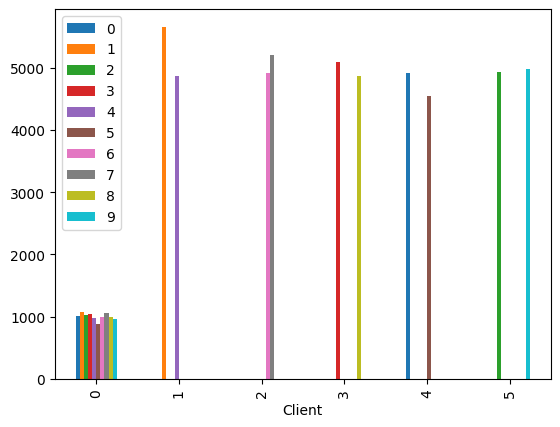

In [4]:
ClientDatasetManager.plot_dataset_splits(res.client_datasets)


In [10]:
res.global_model = res.global_model.to('cuda')

In [6]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to('cuda')
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

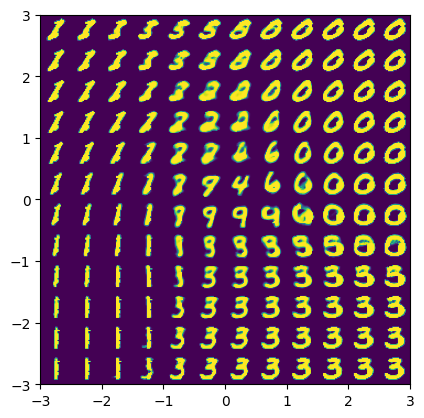

In [7]:
plot_reconstructed(res.global_model, r0=(-3, 3), r1=(-3, 3))


In [25]:
trial_weights = calculate_new_weights(res.global_model.encoder, res.client_datasets, 0.5,0.0)


In [26]:
print(f"Original Weights: {calculate_relative_dataset_sizes(res.client_datasets)}")
print(f"New Weights: {trial_weights}")

Original Weights: [0.16666666666666666, 0.17551666666666665, 0.1688, 0.16598333333333334, 0.15768333333333334, 0.16535]
New Weights: [0.4688833774388207, 0.0, 0.2950004145575001, 0.0, 0.0, 0.2361162080036792]


In [10]:
second_res = federate(FakeArgs(), trial_weights, res.client_datasets)
second_res.serialise("bogus_point_one",FakeArgs())


/home/henry/anaconda3/envs/rp/lib/python3.12/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
  0%|          | 0/10 [00:00<?, ?it/s]


 | Global Training Round : 1 |

Training user 0 in round 1
Finished local epoch 1 out of 10, average loss across batches: 633.2246163726612
Finished local epoch 2 out of 10, average loss across batches: 594.8019218687798
Finished local epoch 3 out of 10, average loss across batches: 589.9430767472383
Finished local epoch 4 out of 10, average loss across batches: 586.8505388976662
Finished local epoch 5 out of 10, average loss across batches: 583.059940411027
Finished local epoch 6 out of 10, average loss across batches: 578.8931861440087
Finished local epoch 7 out of 10, average loss across batches: 576.7607833959495
Finished local epoch 8 out of 10, average loss across batches: 574.7392826930733
Finished local epoch 9 out of 10, average loss across batches: 572.6805571537868
Finished local epoch 10 out of 10, average loss across batches: 571.5427366609026
Training user 1 in round 1
Finished local epoch 1 out of 10, average loss across batches: 492.82891179865055
Finished local epoch 

 10%|█         | 1/10 [01:34<14:13, 94.88s/it]

TEST LOSS AT GLOBAL ROUND 1 totalL: 610.3528356262207

 | Global Training Round : 2 |

Training user 0 in round 2
Finished local epoch 1 out of 10, average loss across batches: 572.5201538474696
Finished local epoch 2 out of 10, average loss across batches: 569.6891156822253
Finished local epoch 3 out of 10, average loss across batches: 568.095061283962
Finished local epoch 4 out of 10, average loss across batches: 567.0833693583301
Finished local epoch 5 out of 10, average loss across batches: 565.0685537544786
Finished local epoch 6 out of 10, average loss across batches: 564.6905956875746
Finished local epoch 7 out of 10, average loss across batches: 563.3256602682126
Finished local epoch 8 out of 10, average loss across batches: 563.0106667682624
Finished local epoch 9 out of 10, average loss across batches: 562.0518347867735
Finished local epoch 10 out of 10, average loss across batches: 561.9144310434913
Training user 1 in round 2
Finished local epoch 1 out of 10, average loss ac

 20%|██        | 2/10 [03:07<12:28, 93.50s/it]

TEST LOSS AT GLOBAL ROUND 2 totalL: 550.2722582870483

 | Global Training Round : 3 |

Training user 0 in round 3
Finished local epoch 1 out of 10, average loss across batches: 562.2547269201582
Finished local epoch 2 out of 10, average loss across batches: 559.5791777592556
Finished local epoch 3 out of 10, average loss across batches: 558.9709146098726
Finished local epoch 4 out of 10, average loss across batches: 558.5578978714669
Finished local epoch 5 out of 10, average loss across batches: 558.4508319052921
Finished local epoch 6 out of 10, average loss across batches: 557.5285562891869
Finished local epoch 7 out of 10, average loss across batches: 557.5273694080912
Finished local epoch 8 out of 10, average loss across batches: 556.7377995776523
Finished local epoch 9 out of 10, average loss across batches: 556.6262350872064
Finished local epoch 10 out of 10, average loss across batches: 555.4267193253633
Training user 1 in round 3
Finished local epoch 1 out of 10, average loss a

 30%|███       | 3/10 [04:42<10:59, 94.17s/it]

TEST LOSS AT GLOBAL ROUND 3 totalL: 544.3027010635376

 | Global Training Round : 4 |

Training user 0 in round 4
Finished local epoch 1 out of 10, average loss across batches: 557.6292176459245
Finished local epoch 2 out of 10, average loss across batches: 555.8493975013685
Finished local epoch 3 out of 10, average loss across batches: 555.3521464159534
Finished local epoch 4 out of 10, average loss across batches: 554.5307212878184
Finished local epoch 5 out of 10, average loss across batches: 554.3358605257265
Finished local epoch 6 out of 10, average loss across batches: 554.1559316064142
Finished local epoch 7 out of 10, average loss across batches: 553.9676206552299
Finished local epoch 8 out of 10, average loss across batches: 553.5175167010848
Finished local epoch 9 out of 10, average loss across batches: 553.1556997116963
Finished local epoch 10 out of 10, average loss across batches: 552.8487008453175
Training user 1 in round 4
Finished local epoch 1 out of 10, average loss a

 40%|████      | 4/10 [06:20<09:34, 95.70s/it]

TEST LOSS AT GLOBAL ROUND 4 totalL: 543.3646948638916

 | Global Training Round : 5 |

Training user 0 in round 5
Finished local epoch 1 out of 10, average loss across batches: 554.4842334917397
Finished local epoch 2 out of 10, average loss across batches: 552.5606160740944
Finished local epoch 3 out of 10, average loss across batches: 552.0348382451732
Finished local epoch 4 out of 10, average loss across batches: 551.5002227588824
Finished local epoch 5 out of 10, average loss across batches: 551.355504904583
Finished local epoch 6 out of 10, average loss across batches: 551.064805729374
Finished local epoch 7 out of 10, average loss across batches: 551.0166970028239
Finished local epoch 8 out of 10, average loss across batches: 550.4775610273811
Finished local epoch 9 out of 10, average loss across batches: 550.5769890463276
Finished local epoch 10 out of 10, average loss across batches: 550.5931684166003
Training user 1 in round 5
Finished local epoch 1 out of 10, average loss acr

 50%|█████     | 5/10 [07:57<08:00, 96.14s/it]

TEST LOSS AT GLOBAL ROUND 5 totalL: 537.7356168457031

 | Global Training Round : 6 |

Training user 0 in round 6
Finished local epoch 1 out of 10, average loss across batches: 552.1266947946731
Finished local epoch 2 out of 10, average loss across batches: 550.2498161170133
Finished local epoch 3 out of 10, average loss across batches: 550.4733937257414
Finished local epoch 4 out of 10, average loss across batches: 549.9170979299363
Finished local epoch 5 out of 10, average loss across batches: 549.8198436566978
Finished local epoch 6 out of 10, average loss across batches: 549.1239981681678
Finished local epoch 7 out of 10, average loss across batches: 549.2508931737037
Finished local epoch 8 out of 10, average loss across batches: 548.7528379403861
Finished local epoch 9 out of 10, average loss across batches: 549.077826044362
Finished local epoch 10 out of 10, average loss across batches: 548.5814601630922
Training user 1 in round 6
Finished local epoch 1 out of 10, average loss ac

 60%|██████    | 6/10 [09:39<06:33, 98.30s/it]

TEST LOSS AT GLOBAL ROUND 6 totalL: 536.8892484909057

 | Global Training Round : 7 |

Training user 0 in round 7
Finished local epoch 1 out of 10, average loss across batches: 550.103081381245
Finished local epoch 2 out of 10, average loss across batches: 549.2503500774408
Finished local epoch 3 out of 10, average loss across batches: 549.0337217294486
Finished local epoch 4 out of 10, average loss across batches: 548.5758540645527
Finished local epoch 5 out of 10, average loss across batches: 548.124629901473
Finished local epoch 6 out of 10, average loss across batches: 548.7046656517466
Finished local epoch 7 out of 10, average loss across batches: 548.7183505501716
Finished local epoch 8 out of 10, average loss across batches: 547.8410766990321
Finished local epoch 9 out of 10, average loss across batches: 548.1692866428642
Finished local epoch 10 out of 10, average loss across batches: 547.829752733753
Training user 1 in round 7
Finished local epoch 1 out of 10, average loss acro

 70%|███████   | 7/10 [11:17<04:54, 98.20s/it]

TEST LOSS AT GLOBAL ROUND 7 totalL: 534.0151856765747

 | Global Training Round : 8 |

Training user 0 in round 8
Finished local epoch 1 out of 10, average loss across batches: 549.480400911562
Finished local epoch 2 out of 10, average loss across batches: 548.1243391097731
Finished local epoch 3 out of 10, average loss across batches: 548.5146645709967
Finished local epoch 4 out of 10, average loss across batches: 547.6812069643835
Finished local epoch 5 out of 10, average loss across batches: 547.4528598663913
Finished local epoch 6 out of 10, average loss across batches: 547.5056885154384
Finished local epoch 7 out of 10, average loss across batches: 547.0225258602458
Finished local epoch 8 out of 10, average loss across batches: 547.5448359592705
Finished local epoch 9 out of 10, average loss across batches: 547.1499073976164
Finished local epoch 10 out of 10, average loss across batches: 546.9669344956708
Training user 1 in round 8
Finished local epoch 1 out of 10, average loss ac

 80%|████████  | 8/10 [12:52<03:14, 97.02s/it]

TEST LOSS AT GLOBAL ROUND 8 totalL: 532.2327710235596

 | Global Training Round : 9 |

Training user 0 in round 9
Finished local epoch 1 out of 10, average loss across batches: 548.7003552868108
Finished local epoch 2 out of 10, average loss across batches: 546.960860720106
Finished local epoch 3 out of 10, average loss across batches: 546.6730805415257
Finished local epoch 4 out of 10, average loss across batches: 546.8855089321258
Finished local epoch 5 out of 10, average loss across batches: 546.966277298654
Finished local epoch 6 out of 10, average loss across batches: 546.1442974114874
Finished local epoch 7 out of 10, average loss across batches: 546.348090104996
Finished local epoch 8 out of 10, average loss across batches: 546.954345703125
Finished local epoch 9 out of 10, average loss across batches: 546.4934919806802
Finished local epoch 10 out of 10, average loss across batches: 546.0183449520426
Training user 1 in round 9
Finished local epoch 1 out of 10, average loss acros

 90%|█████████ | 9/10 [14:26<01:36, 96.04s/it]

TEST LOSS AT GLOBAL ROUND 9 totalL: 532.9357418167115

 | Global Training Round : 10 |

Training user 0 in round 10
Finished local epoch 1 out of 10, average loss across batches: 546.6939611738654
Finished local epoch 2 out of 10, average loss across batches: 546.3527746504279
Finished local epoch 3 out of 10, average loss across batches: 546.7187692435683
Finished local epoch 4 out of 10, average loss across batches: 546.0932539435709
Finished local epoch 5 out of 10, average loss across batches: 545.7233089762888
Finished local epoch 6 out of 10, average loss across batches: 545.0789065998831
Finished local epoch 7 out of 10, average loss across batches: 545.4564315893089
Finished local epoch 8 out of 10, average loss across batches: 546.4529133207479
Finished local epoch 9 out of 10, average loss across batches: 545.4932608634803
Finished local epoch 10 out of 10, average loss across batches: 545.1439875705986
Training user 1 in round 10
Finished local epoch 1 out of 10, average los

100%|██████████| 10/10 [16:00<00:00, 96.05s/it]

TEST LOSS AT GLOBAL ROUND 10 totalL: 535.0807222198487
TRAINING ALL DONE!


In [11]:
a = res.global_loss_manager.validation_total_across_communication

In [12]:
b = second_res.global_loss_manager.validation_total_across_communication

In [13]:
list(zip(a,b))

[(648.5785651428223, 610.3528356262207),
 (629.6985482391358, 550.2722582870483),
 (583.3946553588867, 544.3027010635376),
 (574.2582196960449, 543.3646948638916),
 (563.1185063018798, 537.7356168457031),
 (560.7259799743653, 536.8892484909057),
 (558.8073876098633, 534.0151856765747),
 (555.6730576919556, 532.2327710235596),
 (555.488208531189, 532.9357418167115),
 (555.0193850936889, 535.0807222198487)]